# Analysis of Earth's Mixing Ratio

In this notebook, we explore the utility of using a constant Earth mixing ratio as a "first-order approximation" for scenarios where the actual mixing ratio is non-constant. We specifically aim to demonstrate that this approximation can significantly facilitate the implementation of a multiregression model. By maintaining a constant mixing ratio, we reduce the complexity of the input variables and enhance the model's ability to focus on pattern recognition and feature extraction.

# Imports

In [1]:
import msgpack                          # for data serialization/deserialization
import numpy as np                      # for numerical operations
import pandas as pd                     # for data manipulation
from matplotlib import pyplot as plt    # for creating plots
from collections import OrderedDict     # for dictionaries that maintain order

# Project-specific imports
from geexhp.pypsg import PSG
from geexhp.core import datavis, datamod
datavis.configure_matplotlib()

# Present Earth

In [2]:
# Default HabEx Configuration Loading
with open("../geexhp/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))

# Earth with constant mixing ratio

In [3]:
# Initializes an empty list to store abundance values for each atmospheric layer
abundances = []  

for i in range(60):
    # Retrieves and splits the abundance data from the configuration for each layer
    layer_abundances = config[f"ATMOSPHERE-LAYER-{i + 1}"].split(",")[2:]
    # Converts string values to floats and appends them to the abundances list
    abundances.append([float(value) for value in layer_abundances])

# Sums up the abundances across all layers
total_abundances = np.sum(np.array(abundances), axis=0) 

# Normalizes the summed abundances
normalized_abundances = total_abundances / np.sum(total_abundances)

In [5]:
molecular_weight = [
    18.01528,  # Water (H2O)
    44.0095,   # Carbon Dioxide (CO2)
    47.9982,   # Ozone (O3)
    44.0128,   # Nitrous Oxide (N2O)
    28.0101,   # Carbon Monoxide (CO)
    16.04246,  # Methane (CH4)
    31.9988,   # Oxygen (O2)
    30.0061,   # Nitric Oxide (NO)
    64.066,    # Sulfur Dioxide (SO2)
    46.0055,   # Nitrogen Dioxide (NO2)
    17.03052,  # Ammonia (NH3)
    63.0128,   # Nitric Acid (HNO3)
    17.0073,   # Hydroxyl (OH)
    20.0063,   # Hydrogen Fluoride (HF)
    36.4609,   # Hydrochloric Acid (HCl)
    80.912,    # Hydrobromic Acid (HBr)
    127.9124,  # Hydroiodic Acid (HI)
    50.4515,   # Hypochlorous Acid (ClO)
    60.0751,   # Carbonyl Sulfide (OCS)
    30.026,    # Formaldehyde (H2CO)
    52.4605,   # Hypochlorous Acid (HOCl)
    28.0134,   # Nitrogen (N2)
    27.0253,   # Hydrogen Cyanide (HCN)
    50.4875,   # Methyl Chloride (CH3Cl)
    34.0147,   # Hydrogen Peroxide (H2O2)
    26.0373,   # Acetylene (C2H2)
    30.0690,   # Ethane (C2H6)
    33.9972    # Phosphine (PH3)
]

# Weight Calculation
# Multiplies molecular weights by normalized abundances and sums them to 
# calculate the average molecular weight of the atmosphere
average_molecular_weight = np.sum(molecular_weight * normalized_abundances)

# Retrieves the configured atmosphere weight from the configuration
config_atmosphere_weight = config["ATMOSPHERE-WEIGHT"]  
average_molecular_weight, config_atmosphere_weight

(28.76769407182519, 28.97)

In [6]:
# Copying Configuration for Testing
config_test = config.copy()

# Updates the atmospheric weight in the test config
config_test["ATMOSPHERE-WEIGHT"] = np.sum(molecular_weight * normalized_abundances)  

# Updating Layer Information
for i in range(60):
    layer_key = f"ATMOSPHERE-LAYER-{i + 1}"  
    original_values = config_test[layer_key].split(",")[:2] 
    abundance_values = ",".join([f"{value}" for value in normalized_abundances])  
    config_test[layer_key] = ",".join(original_values + [abundance_values])  
# len(config_test[f"ATMOSPHERE-LAYER-1"].split(",")) == len(config[f"ATMOSPHERE-LAYER-1"].split(","))

# Run PSG

In [7]:
psg = PSG(server_url= "http://127.0.0.1:3000/api.php", timeout_seconds = 200)

Testing connection to PSG at http://127.0.0.1:3000/api.php ...
Connected to PSG with success.


In [8]:
# Function to configure and run PSG model for a specific instrument
def configure_and_run(model_config, instrument):
    modified_config = model_config.copy() 
    datamod.set_instrument(modified_config, instrument)  
    return psg.run(modified_config)

# Configurations for HWC instrument
result = configure_and_run(config, 'HWC') 
result_constant = configure_and_run(config_test, 'HWC') 

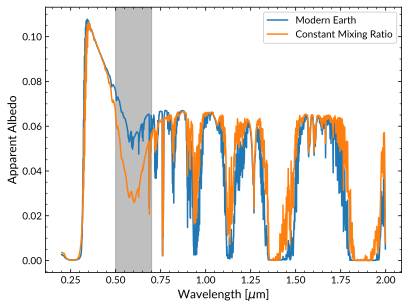

In [9]:
columns = ["WAVELENGTH", "ALBEDO"] 
df_earth = pd.DataFrame(result["spectrum"][:, [0, 1]], columns=columns)  
df_earth_constant = pd.DataFrame(result_constant["spectrum"][:, [0, 1]], columns=columns)

_, ax = plt.subplots()
datavis.plot_spectrum(df_earth, ax = ax, label="Modern Earth")
datavis.plot_spectrum(df_earth_constant, ax = ax, label="Constant Mixing Ratio")
ax.axvspan(0.5, 0.7, color='gray', alpha=0.5);

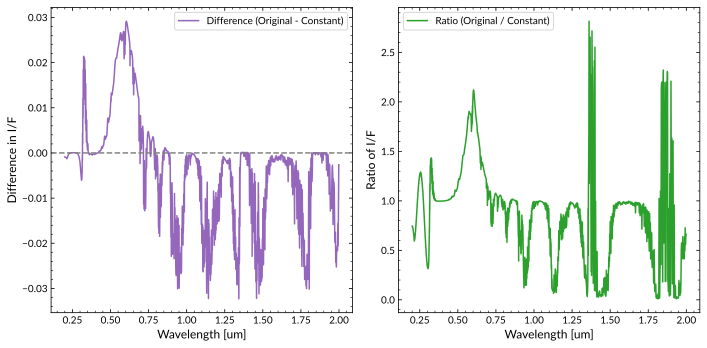

In [13]:
difference = df_earth["ALBEDO"] - df_earth_constant["ALBEDO"]
ratio = df_earth["ALBEDO"] / df_earth_constant["ALBEDO"]

fig, (ax_diff, ax_ratio) = plt.subplots(1, 2, figsize=(10, 5))

ax_diff.plot(df_earth["WAVELENGTH"], difference, label="Difference (Original - Constant)", color="tab:purple")
ax_diff.set(xlabel="Wavelength [um]", ylabel="Difference in I/F")
ax_diff.axhline(0, color='gray', linestyle='--') 
ax_diff.legend()

ax_ratio.plot(df_earth["WAVELENGTH"], ratio, label="Ratio (Original / Constant)", color="tab:green")
ax_ratio.set(xlabel="Wavelength [um]", ylabel="Ratio of I/F")
ax_ratio.legend()

plt.tight_layout()

- **Variability and Peaks**: The difference plot shows significant variability across the wavelength spectrum, with noticeable peaks particularly around 0.65. These peaks suggest wavelengths where the constant mixing ratio assumption diverges most from the variable mixing ratio.

- **Negative and Positive Differences**: The presence of both negative and positive differences indicates that the constant model sometimes underestimates and sometimes overestimates the spectral intensity compared to the non-constant model.

- **Overall Trend**: The differences generally oscillate around zero, which could imply that the constant assumption doesn't consistently over- or underestimate across all wavelengths but affects specific spectral bands more than others.

- **Ratio Values**: The ratio plot, which typically ranges from slightly below 0.5 to over 2.5, indicates substantial relative differences in some areas. Ratios above 1 denote wavelengths where the constant model yields higher spectral values than the variable model, and vice versa for ratios below 1.

- **Significant Spikes**: The sharp spikes, especially the major one around 1.4 μm, suggest strong disparities that could be linked to specific atmospheric components or interactions that are not adequately represented by a constant mixing ratio.